In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
import seaborn as sns
from pathlib import Path
from scipy.stats import halfnorm
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Bayesian Hypothesis Testing for comparing LeBron James and Anthony Davis's points scored per game.

Amos Colombo, Christian Pala

Note: based on professor Corani's notebook: Bayesian-t-test, presented during the course lectures.

Import the relevant data for the first test:

In [25]:
df = pd.read_pickle(Path('..', 'data', 'dataset.pkl'))
# select LeBron James and Anthony Davis
df = df[df['PLAYER_NAME'].isin(['LeBron James', 'Anthony Davis'])]
df.head()

,PLAYER_ID,PLAYER_NAME,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,2544.0,LeBron James,"[3.114, 15.114, 3.114, 0.114, 8.114, 0.114, 13...","[15.114, 3.114, 0.114, 8.114, 0.114, 13.114, 1...","[3.114, 0.114, 8.114, 0.114, 13.114, 1.114, 5....","[0.114, 8.114, 0.114, 13.114, 1.114, 5.114, 1....","[8.114, 0.114, 13.114, 1.114, 5.114, 1.114, -9...","[0.114, 13.114, 1.114, 5.114, 1.114, -9.886, 4...","[13.114, 1.114, 5.114, 1.114, -9.886, 4.114, -...","[1.114, 5.114, 1.114, -9.886, 4.114, -8.886, 1...",...,23.0,29.0,33.0,30.0,23.0,25.0,33.0,29.0,23.0,13.0
2,203076.0,Anthony Davis,"[-5.886, 3.114, -2.886, -9.886, 7.114, 9.114, ...","[3.114, -2.886, -9.886, 7.114, 9.114, 2.114, 9...","[-2.886, -9.886, 7.114, 9.114, 2.114, 9.114, 2...","[-9.886, 7.114, 9.114, 2.114, 9.114, 2.114, 6....","[7.114, 9.114, 2.114, 9.114, 2.114, 6.114, 12....","[9.114, 2.114, 9.114, 2.114, 6.114, 12.114, -1...","[2.114, 9.114, 2.114, 6.114, 12.114, -11.886, ...","[9.114, 2.114, 6.114, 12.114, -11.886, 4.114, ...",...,33.0,34.0,14.0,17.0,24.0,27.0,26.0,15.0,25.0,40.0


Preprocess the data:

In [7]:
# select columns for HP 1 43-83
df = df.iloc[:, 43:84]

# cast to float numpy arrays for pymc3
points_lebron = df.iloc[0, :].values
points_ad = df.iloc[1, :].values
points_lebron = np.array(points_lebron, dtype=float)
points_ad = np.array(points_ad, dtype=float)

During our prior modelling, we noticed we cannot reasonably model the points per game distribution for a player, as a normal. This is mainly because the left side of the distribution is capped at 0, with most of the mass around 10, but on the right side values of 50 are possible, resulting in a positively skewed distribution.
After discussing this with professor Corani we selected a log-normal distribution, which allows for long tails. We transform our points per game in the natural log scale:

In [8]:
points_lebron_log = np.log(points_lebron)
points_ad_log = np.log(points_ad)

Data visualization:

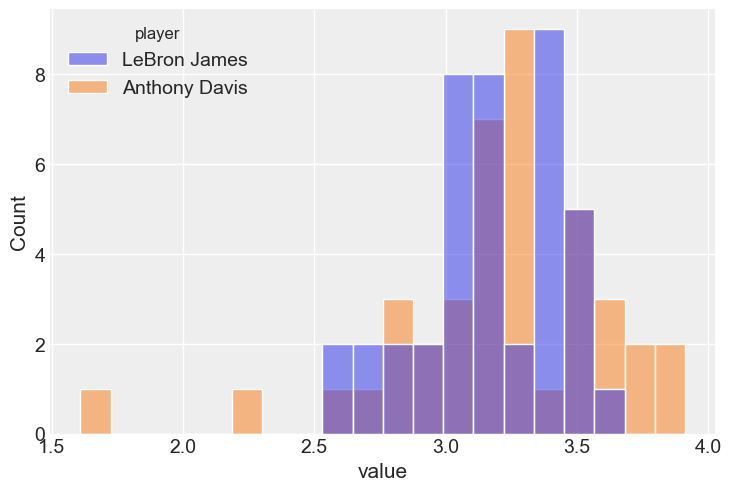

In [9]:
y  = pd.DataFrame(dict(value=np.r_[points_lebron_log, points_ad_log], player=np.r_[["LeBron James"]*len(points_lebron), ['Anthony Davis']*len(points_ad)]))
sns.histplot(data=y, x="value", hue="player", bins=20);

We assume the logarithmic values of the scores are approximately normal, although it's clearly an approximation.

In [10]:
print(f"Sample mean points LeBron James: {np.mean(points_lebron_log):.3f}")
print(f"Sample mean points Anthony Davis: {np.mean(points_ad_log):.3f}")

Sample mean points LeBron James: 3.175
Sample mean points Anthony Davis: 3.201


# Research questions

* The sample mean of points per game is superior for Anthony Davis, but:

    * there is a lot of variability within games
    * there may be outliers


* Is the expected points per game credibly higher for Anthony Davis? In other words, can we reject the hypothesis that the two players have equal means?
* Which is the probability of Anthony Davis scoring more points in a game than LeBron James?
* If there is a difference, is it significant?
* If there is a difference between means, can we expect a large, a medium or a low difference in the points per game?

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{\text{Anthony}$, $\bar{y}_{\text{LeBron}}$)

    * sample standard deviations ($s_{\text{Anthony}}, s_{\text{LeBron}}$)

    * numerosity ($n_{\text{Anthony}}, n_{\text{LeBron}}$)


* The sample are drawn from two populations with unknown parameters $\mu_{\text{Anthony}}, \mu_{\text{LeBron}}, \sigma_{\text{Anthony}}, \sigma_{\text{LeBron}}$.

# Background information to set the prior

* <a href="https://www.basketball-reference.com/leagues/NBA_stats_per_game.html"> Prior mean reference </a> The average points per game in the NBA for the season 2019-2020 was 111.8, with 13 players per roster. Rounding to a meaningful value, that turns out to be 9 points per game as the average.
* Since we have a dataset with information on all active players in the 2019-2020 season, we also computed both mean and standard deviation, the mean is quite close, so we selected a value of $\ln(9)$ for our $\mu_{player}$ prior.
* We decided a reasonable prior for the mean points per game lies between 5 and 14, based on the empirical values and the NBA statistics we referenced.

Difference between empyrical values and results from our research:

In [11]:
priors = pd.read_csv(Path('..', 'data', 'prior_information.csv'))
mu = priors["mean"]
sigma = priors["std"]
print(f"Difference in average points between reference value and empirical 2019-2020 value from the dataset: {float(111.8/13 - mu.values):.3f}")
print(f"Prior standard deviation: {float(sigma):.3f}")

Difference in average points between reference value and empirical 2019-2020 value from the dataset: 0.615
Prior standard deviation: 4.641


# Prior for $\mu_{\text{Anthony}}$ and $\mu_{\text{Lebron}}$

* The mean points per game of the population lie in the (3, 16) interval, with $\mu$ being 9; we interpret this as an interval of $\pm 4 \sigma$ around the mean.

$$
\mu_{\text{Anthony}} \sim \text{LogNormal}(\mu, \sigma) \sim \text{LogNormal}(\ln(9), \ln(1 + (4/9)^2))$
$$
$$
\mu_{\text{LeBron}} \sim \text{LogNormal}(\mu, \sigma) \sim \text{LogNormal}(\ln(9), \ln(1 + (4/9)^2))$
$$


* The values are derived from the properties of log normal distributions where:
    * $\mu_{\text{log}} = \ln(\mu_{\text{original}})$
    * $\sigma_{\text{log}} = \ln(1 + (\frac{\sigma_{\text{original}}}{\mu_{\text{original}}})^2)$


* We assign the same priors to both players, so that we are not favoring a player over the other, a priori.

# Prior for $\sigma_{\text{Lebron}}$ and $\sigma_{\text{Anthony}}$

* We know for the normal case we calibrated with a median of 4.5, here we repeat for $\ln(4.5) \sim 1.5$ and obtain:
$$
\sigma_{\text{Anthony}} \sim \text{HalfNormal}(\ln(10))$
$$
$$
\sigma_{\text{LeBron}} \sim \text{HalfNormal}(\ln(10))
$$

In [12]:
pd.DataFrame(halfnorm.rvs(scale=np.log(10), size=10000)).describe()

,0
count,10000.000000
mean,1.848971
std,1.392717
min,0.000382
25%,0.752851
50%,1.565864
75%,2.649464
max,8.809838


# Likelihood
* Assuming a log-Gaussian distribution of the observations, we have:

    $$\vec{y}_{\text{player}} \sim \text{LogNormal}(\mu_{\text{player}}, \sigma_{\text{player}})$$

for both Anthony and LeBron, where we use the vector notation to make it clear that these are array of measures.

#  The probabilistic model

* We assume the two players to have different $\sigma$ on their mean points per game:

\begin{align*}
\mu_{\text{Anthony}} & \sim \text{LogNormal}(\ln(9), \ln(1 + (4/9)^2) \\
\sigma_{\text{Anthony}} & \sim \text{HalfNormal} (\ln(10)) \\
\vec{y}_{\text{Anthony}}  & \sim \text{LogNormal}(\mu_{\text{Anthony}}, \sigma_{\text{Anthony}})\\
\\
\mu_{\text{LeBron}} & \text{LogNormal}(\ln(9), \ln(1 + (4/9)^2)  \\
\sigma_{\text{LeBron}} & \sim \text{HalfNormal} (\ln(10)) \\
\vec{y}_{\text{LeBron}}  & \sim \text{LogNormal}(\mu_{\text{LeBron}}, \sigma_{\text{LeBron}})\\
\end{align*}


# Comparing two means $\mu_{Anthony}$ and $\mu_{LeBron}$

We consider  the difference between the means of the two players:
$$\mu_{\text{Anthony}} - \mu_{\text{LeBron}}$$

* We will have the posterior samples of ($\mu_{\text{Anthony}}$ - $\mu_{\text{LeBron}}$) in the trace.

In [13]:
with pm.Model() as log_normal_model:
    # priors
    mu_Anthony = pm.Lognormal('mu_Anthony', mu=np.log(9), sd=np.log(1 + (4/9) ** 2))
    mu_LeBron = pm.Lognormal('mu_LeBron', mu=np.log(9), sd=np.log(1 + (4/9) ** 2))
    sigma_Anthony = pm.HalfNormal('sigma_Anthony', sigma=np.log(10))
    sigma_LeBron = pm.HalfNormal('sigma_LeBron', sigma=np.log(10))

    # likelihood of player Anthony
    y_Anthony = pm.Lognormal('y_Anthony', mu=mu_Anthony, sigma=sigma_Anthony, observed=points_ad_log)

    # likelihood of player LeBron
    y_LeBron = pm.Lognormal('y_LeBron', mu=mu_LeBron, sigma=sigma_LeBron, observed=points_lebron_log)

    # parameter of interest
    diff_of_means = pm.Deterministic('diff_of_means', mu_Anthony - mu_LeBron)

In [14]:
with log_normal_model:
    log_normal_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_LeBron, sigma_Anthony, mu_LeBron, mu_Anthony]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.


# Checking convergence

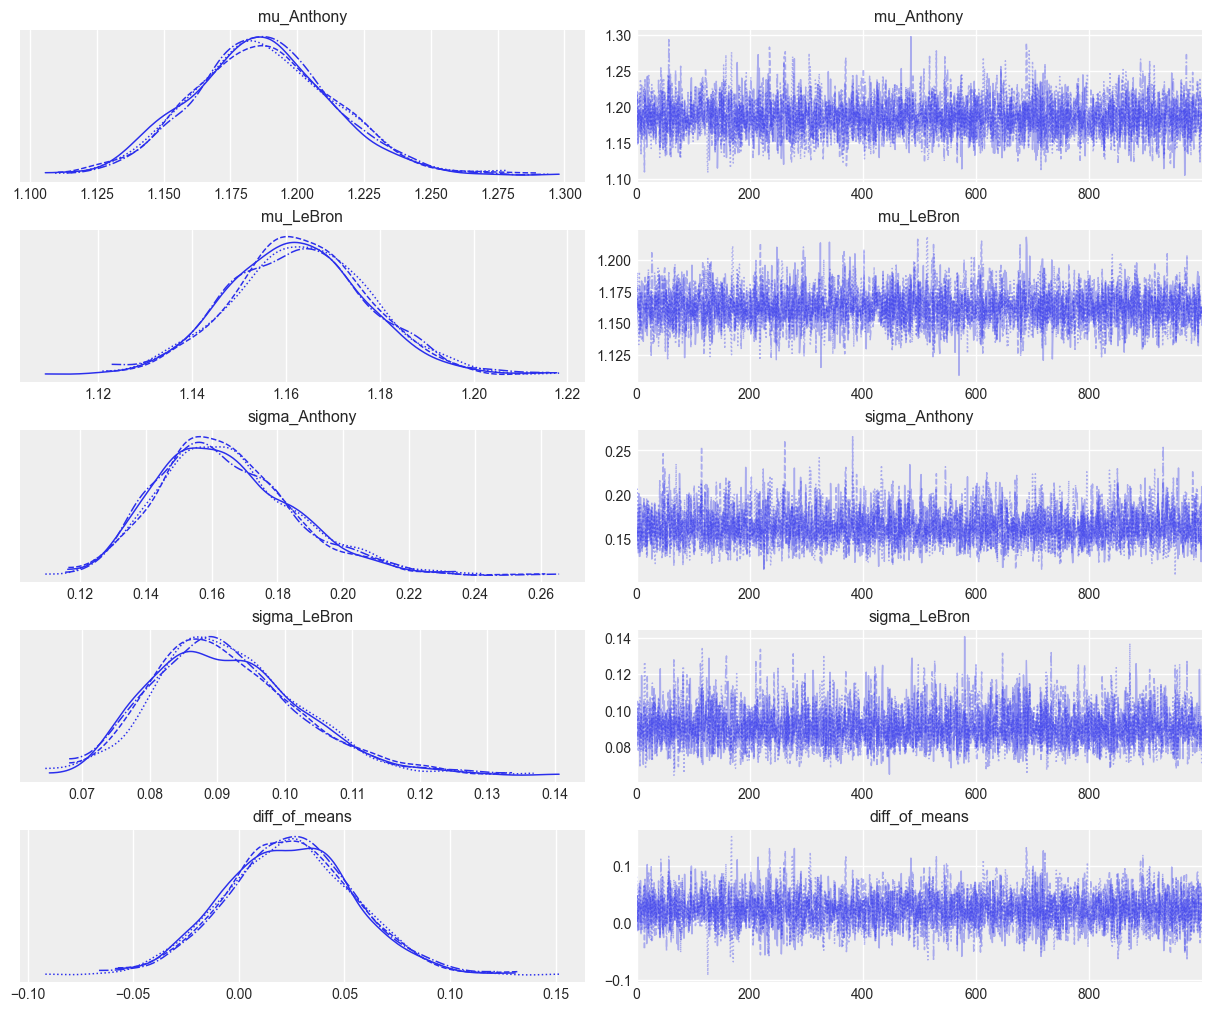

In [15]:
az.plot_trace(log_normal_trace);

The convergence seems fine to us.

## Question 1:

In [16]:
az.summary(log_normal_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_Anthony,1.187,0.026,1.136,1.239,0.0,0.0,4447.0,2695.0,1.0
mu_LeBron,1.163,0.015,1.134,1.192,0.0,0.0,4507.0,2746.0,1.0
sigma_Anthony,0.164,0.020,0.129,0.207,0.0,0.0,4072.0,2485.0,1.0
sigma_LeBron,0.091,0.011,0.072,0.114,0.0,0.0,4817.0,3021.0,1.0
diff_of_means,0.024,0.030,-0.037,0.081,0.0,0.0,4430.0,2830.0,1.0


Since 0 is in the 95% HDI interval, we cannot reject the hypothesis that two players have equal means, it's a plausible value.

## Question 2:

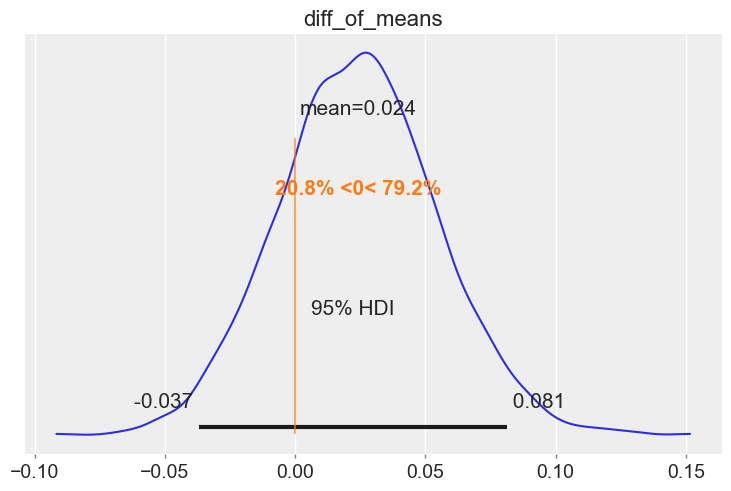

In [17]:
az.plot_posterior(log_normal_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

These values suggest it's more likely for Anthony Davis to score more points than LeBron James, compared to the normal model with our priors.

## Question 3:

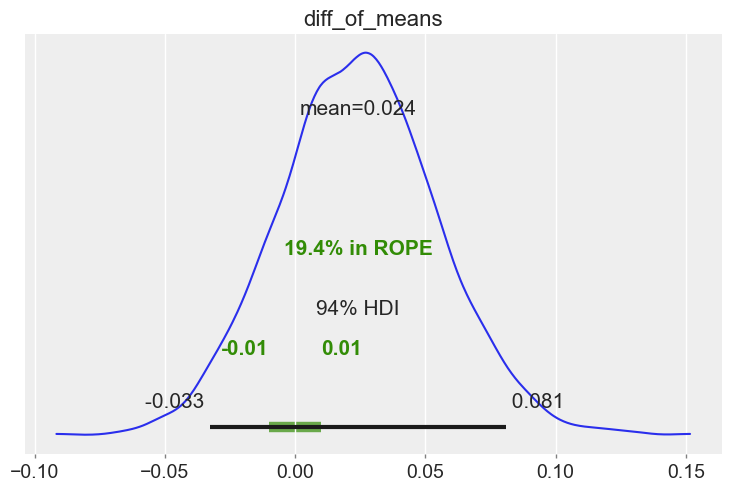

In [22]:
# Pass the new variable to the `var_names` parameter
az.plot_posterior(log_normal_trace, var_names="diff_of_means", rope=(-0.01, 0.01));

The definition of the rope is arbitrary, be we can see the model considers both mean basically equivalent.

In [23]:
samples = az.extract_dataset(log_normal_trace,)
diff_samples = samples.diff_of_means.values
p_significant_large = ((diff_samples > 0.05).sum() ) / len(diff_samples)
p_significant_medium = (np.logical_and(diff_samples > np.log(0.02), diff_samples < 0.05).sum()) / len(diff_samples)
p_significant_small = 1 -  p_significant_medium  -  p_significant_large

print(f"p(large point difference) = {p_significant_large:.3f}")
print(f"p(medium point difference) = {p_significant_medium:.3f}")
print(f"p(small point difference): = {p_significant_small:.3f}")

p(large point difference) = 0.193
p(medium point difference) = 0.807
p(small point difference): = -0.000


From the tests we conclude it's likely both players have very similar mean points per game.

# Posterior predictive checks

C:\Users\light\OneDrive\Documents\Study\SUPSI\Year 3\bayesian_data_analysis_and_probabilistic_programming\coding\venv\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


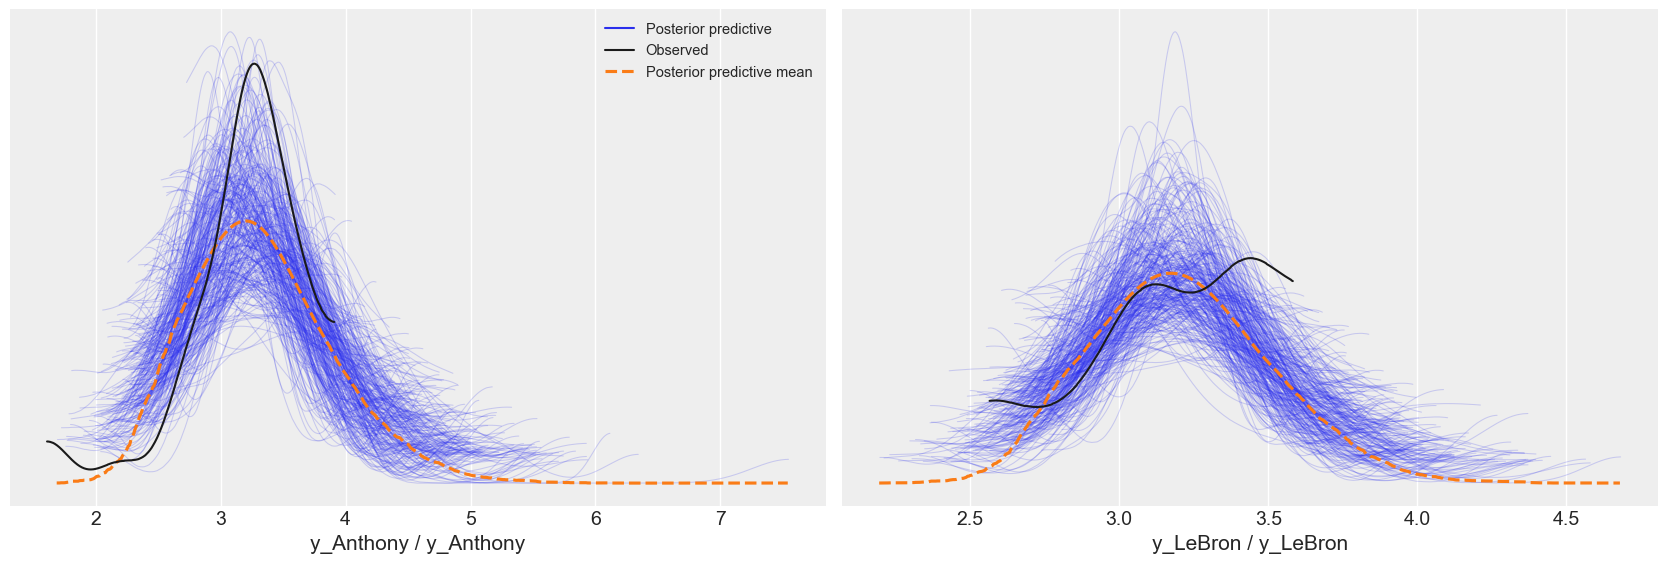

In [20]:
with log_normal_model:
     ppc = pm.sample_posterior_predictive(log_normal_trace, samples=300)

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=log_normal_model));

The LogNormal model is also performing reasonably.